# EMOTION RECOGNITION - [FER-13]

## Libraries Needed


In [ ]:
import tensorflow as tf
import dask as dk
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [ ]:
!pwd
!ls

In [ ]:
img_array = cv.imread("./images/images/train/0/0.jpg")
print(img_array.shape)
plt.imshow(img_array)

In [ ]:
DATA_DIRECTORY="./images/images/train/"
CLASSES = [str(x) for x in range(7)]
IMG_SIZE = 224
X = []
y = []

## Dataset & Image Sizing

In [ ]:
%%time
def create_training_data():
    for category in CLASSES:
        path = os.path.join(DATA_DIRECTORY, category)
        class_num = CLASSES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                new_array = np.array(new_array).reshape(IMG_SIZE, IMG_SIZE, 3)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                print(e)
            
                      
create_training_data()
print(X[0])
TRAIN_SIZE = X[0].shape[0]

In [ ]:
def shuffle_arrays(arrays, set_seed=-1):
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32-1) - 1) if set_seed < 0 else set_seed
    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

shuffle_arrays([X, y])


In [ ]:
import h5py

with h5py.File('data.hdf5', 'w') as f:
    f.create_dataset('X', data = X)
    f.create_dataset('y', data = y)

## PROCESSING SAVED hdf5 DATA

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


In [1]:
import gc
gc.get_stats()

[{'collections': 210, 'collected': 2589, 'uncollectable': 0},
 {'collections': 19, 'collected': 598, 'uncollectable': 0},
 {'collections': 1, 'collected': 0, 'uncollectable': 0}]

In [4]:
import tensorflow as tf
import dask as dk
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [6]:
INDEX=0
PROCESS_SIZE=100
import h5py


In [5]:
hf = h5py.File('data.hdf5', 'r')
TRAIN_SIZE=8000#hf['X'].shape[0] 
IMG_SIZE = hf['X'].shape[2]
print(hf['X'].shape)

NameError: name 'h5py' is not defined

In [5]:
def get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE):
    if(INDEX+PROCESS_SIZE > TRAIN_SIZE):
        d1 = np.array(hf['X'][INDEX:TRAIN_SIZE])
        d2 = np.array(hf['y'][INDEX:TRAIN_SIZE])
    elif (INDEX >= TRAIN_SIZE):
        return -1
    else:
        d1 = np.array(hf['X'][INDEX:INDEX+PROCESS_SIZE])
        d2 = np.array(hf['y'][INDEX:INDEX+PROCESS_SIZE])
    global X
    X = np.array(d1, dtype='float32')
    a=np.array(255, dtype='float32')
    X/=a
    global y
    y = np.array(d2)
    INDEX+=PROCESS_SIZE
    return INDEX
    

In [7]:
model = tf.keras.applications.MobileNetv2()
model.summary()

2022-04-24 23:33:32.830738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:33:32.860881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:33:32.861350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-24 23:33:32.862482: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2022-04-24 23:33:34.824219: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [10]:
base_input = model.layers[0].input #1st layer
base_output = model.layers[-2].output #layer of second from back

final_output = tf.keras.layers.Dense(128)(base_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(64)(final_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(7, activation="softmax")(final_output)

new_model = tf.keras.Model(inputs = base_input, outputs = final_output)
new_model.summary()

new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"], run_eagerly=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Keras Fit using Image Generator

In [8]:
from h5imagegenerator import HDF5ImageGenerator
train_generator = HDF5ImageGenerator(
        src='data.hdf5',
        X_key='X',
        y_key='y',
        scaler=True,
        num_classes=7,
        batch_size=64,
        mode='train')

In [11]:
model_info = new_model.fit(
        train_generator,
        epochs=10,
        use_multiprocessing=True)

model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

emotion_model.save_weights('emotion_model.h5')

Epoch 1/10


2022-04-24 23:33:55.977583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-24 23:33:57.002430: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-24 23:33:57.002596: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-24 23:33:57.085489: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

ResourceExhaustedError: Exception encountered when calling layer "block2_conv2" (type Conv2D).

OOM when allocating tensor with shape[64,128,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received:
  • inputs=tf.Tensor(shape=(64, 112, 112, 128), dtype=float32)

## Keras Fit - part by part of data

In [8]:
INDEX=0
while True:
    if(INDEX != 0):
        new_model = tf.keras.models.load_model("model.h5")
    print("Training Completed for ", INDEX)
    INDEX=get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE)
    if(INDEX == -1):
        break
    new_model.fit(X, y, batch_size=1)
    new_model.save('model.h5') 
    

Training Completed for  0


2022-04-24 23:31:22.212540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


100/100 [==============================] - 10s 72ms/step - loss: 7.2155 - accuracy: 0.2000
Training Completed for  100
100/100 [==============================] - 7s 59ms/step - loss: 2.3421 - accuracy: 0.1800


2022-04-24 23:31:55.768345: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-24 23:31:55.768517: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-24 23:31:55.768536: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 91, Chunks in use: 91. 22.8KiB allocated for chunks. 22.8KiB in use in bin. 5.5KiB client-requested in use in bin.
2022-04-24 23:31:55.768542: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 20, Chunks in use: 20. 10.5KiB allocated for chunks. 10.5KiB in use in bin. 10.0KiB client-requested in use in bin.
2022-04-24 23:31:55.768547: I ten

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
INDEX=8000
PROCESS_SIZE=800
TRAIN_SIZE=16000
while True:
    if(INDEX != 0):
        new_model = tf.keras.models.load_model("model.h5")
    print("Training Completed for ", INDEX)
    INDEX=get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE)
    if(INDEX == -1):
        break
    new_model.fit(X, y, batch_size=1)
    new_model.save('model.h5') 
    del new_model
    

In [ ]:
new_model.save('model.h5') 

## Restart Kernel for space 

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


## Testing an Image 

In [18]:
import tensorflow as tf
import dask as dk
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import model_from_json

In [19]:
new_model = tf.keras.models.load_model("model.h5")
IMG_SIZE = 224
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')


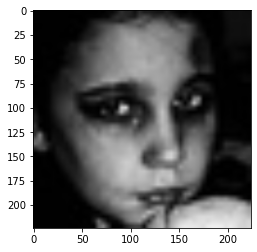

In [46]:
frame = cv.imread('./images/images/validation/5/20.jpg')
frame = cv.resize(frame, (IMG_SIZE, IMG_SIZE))
frame.reshape
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
gray = np.array(frame).reshape(IMG_SIZE, IMG_SIZE, 3)
final_image = np.expand_dims(gray, axis = 0)
final_image = final_image/255


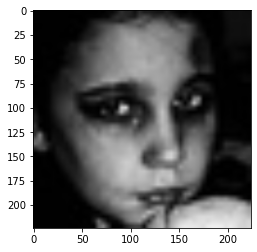

In [47]:
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
gray = np.array(frame).reshape(IMG_SIZE, IMG_SIZE, 3)
final_image = np.expand_dims(gray, axis = 0)
final_image = final_image/255


In [48]:
predictions = new_model.predict(final_image)
print(predictions[0])
np.argmax(predictions)

[3.5974520e-01 9.3565944e-08 6.8962239e-05 1.8909686e-06 6.2824738e-01
 5.1666786e-05 1.1884791e-02]


4

## Slicing MobileNetv2 for Valuable Feature Extraction

In [50]:
base_input = new_model.layers[0].input #1st layer
base_output = new_model.layers[-6].output #layer of second from back

model_cut = tf.keras.Model(inputs = base_input, outputs = base_output)
model_cut.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [51]:
model_cut.predict(final_image)

array([[0.18941665, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [52]:
hf = h5py.File('data.hdf5', 'r')
TRAIN_SIZE=hf['X'].shape[0]
IMG_SIZE = hf['X'].shape[2]


In [53]:
def get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE):
    if(INDEX+PROCESS_SIZE > TRAIN_SIZE):
        d1 = np.array(hf['X'][INDEX:TRAIN_SIZE])
        d2 = np.array(hf['y'][INDEX:TRAIN_SIZE])
    elif (INDEX >= TRAIN_SIZE):
        return -1
    else:
        d1 = np.array(hf['X'][INDEX:INDEX+PROCESS_SIZE])
        d2 = np.array(hf['y'][INDEX:INDEX+PROCESS_SIZE])
    global X
    X = np.array(d1, dtype='float32')
    a=np.array(255, dtype='float32')
    X/=a
    global y
    y = np.array(d2)
    INDEX+=PROCESS_SIZE
    return INDEX
    

In [56]:
INDEX=0
X_data = []
y_data = []
while True:
    print("Predicing Completed for ", INDEX)
    INDEX=get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE)
    if(INDEX == -1):
        break
    y_pred = new_model.predict(X)
    y_real = []
    for i in range(PROCESS_SIZE):
        y_real.append(y[i])
        
    for i in range(PROCESS_SIZE):
        X_data.append(y_pred[i].reshape(-1))
        y_data.append(y_real[i])
        

Predicing Completed for  0
Predicing Completed for  100
Predicing Completed for  200
Predicing Completed for  300
Predicing Completed for  400
Predicing Completed for  500
Predicing Completed for  600
Predicing Completed for  700
Predicing Completed for  800
Predicing Completed for  900
Predicing Completed for  1000
Predicing Completed for  1100
Predicing Completed for  1200
Predicing Completed for  1300
Predicing Completed for  1400
Predicing Completed for  1500
Predicing Completed for  1600
Predicing Completed for  1700
Predicing Completed for  1800
Predicing Completed for  1900
Predicing Completed for  2000
Predicing Completed for  2100
Predicing Completed for  2200
Predicing Completed for  2300
Predicing Completed for  2400


2022-04-25 01:33:32.025688: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 149.64MiB (rounded to 156905472)requested by op model/block_1_pad/Pad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-25 01:33:32.026110: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-25 01:33:32.026132: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 310, Chunks in use: 309. 77.5KiB allocated for chunks. 77.2KiB in use in bin. 32.9KiB client-requested in use in bin.
2022-04-25 01:33:32.026140: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 289, Chunks in use: 289. 195.2KiB allocated for chunks. 195.2KiB in use in bin. 167.2KiB client-requested in use in bin.
2022-04

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block_1_pad/Pad' defined at (most recent call last):
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4711/3718967646.py", line 1, in <cell line: 1>
      predictions = new_model.predict(final_image)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
      return self(x, training=False)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/layers/convolutional.py", line 3235, in call
      return backend.spatial_2d_padding(
    File "/home/mnk/python/envs/tensorflow/lib/python3.8/site-packages/keras/backend.py", line 3761, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'model/block_1_pad/Pad'
OOM when allocating tensor with shape[3072,113,113] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block_1_pad/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_20068]

In [ ]:
import h5py
with h5py.File('feature_data.hdf5', 'w') as f:
    f.create_dataset('X', data = X_data)
    f.create_dataset('y', data = y_data)

## Adding SVM Layer - Sklearn env

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


In [1]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import h5py
import numpy as np

In [2]:
hf = h5py.File('feature_data.hdf5', 'r')
TRAIN_SIZE=hf['X'].shape[0]
FEATURE_SIZE=hf['X'].shape[1]

In [3]:
X = np.array(hf['X'][:])
y = np.array(hf['y'][:])

svm_model = SVC(kernel = 'rbf', C = 1).fit(X, y)
svm_predictions = svm_model.predict(X)
 
accuracy = svm_model.score(X, y)
cm = confusion_matrix(y, svm_predictions)


## Visualization


0.6038666666666667


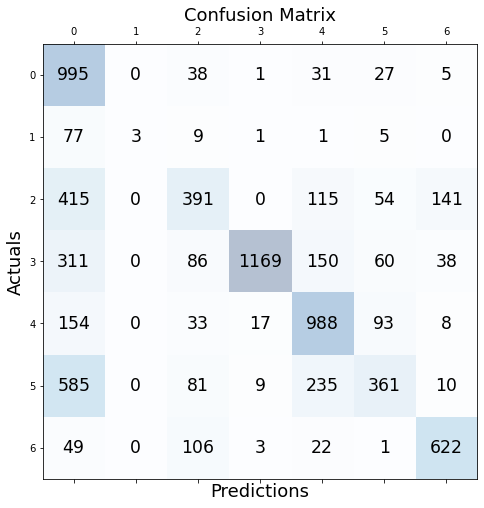

In [4]:
print(accuracy)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Save SVM model

In [15]:
import pickle
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm_model, file)

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Validation

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

## Conversion of Validation Set into HDF5

(48, 48, 3)


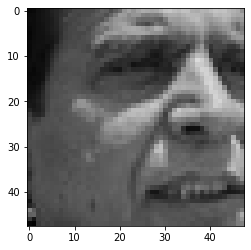

In [3]:
img_array = cv.imread("./images/images/validation/0/23.jpg")
print(img_array.shape)
plt.imshow(img_array)

In [4]:
DATA_DIRECTORY="./images/images/validation/"
CLASSES = [str(x) for x in range(7)]
IMG_SIZE = 224
X = []
y = []

In [5]:
%%time
def create_training_data():
    for category in CLASSES:
        path = os.path.join(DATA_DIRECTORY, category)
        class_num = CLASSES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                new_array = np.array(new_array).reshape(IMG_SIZE, IMG_SIZE, 3)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                print(e)
            
                      
create_training_data()
print(X[0], y[0])
TRAIN_SIZE = X[0].shape[0]

[[[ 53  53  53]
  [ 53  53  53]
  [ 52  52  52]
  ...
  [146 146 146]
  [147 147 147]
  [147 147 147]]

 [[ 53  53  53]
  [ 53  53  53]
  [ 52  52  52]
  ...
  [146 146 146]
  [147 147 147]
  [147 147 147]]

 [[ 53  53  53]
  [ 53  53  53]
  [ 52  52  52]
  ...
  [146 146 146]
  [147 147 147]
  [147 147 147]]

 ...

 [[157 157 157]
  [157 157 157]
  [156 156 156]
  ...
  [ 92  92  92]
  [ 92  92  92]
  [ 92  92  92]]

 [[158 158 158]
  [158 158 158]
  [157 157 157]
  ...
  [ 92  92  92]
  [ 92  92  92]
  [ 92  92  92]]

 [[158 158 158]
  [158 158 158]
  [157 157 157]
  ...
  [ 92  92  92]
  [ 92  92  92]
  [ 92  92  92]]] 0
CPU times: user 1.07 s, sys: 999 ms, total: 2.07 s
Wall time: 3.29 s


In [6]:
def shuffle_arrays(arrays, set_seed=-1):
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32-1) - 1) if set_seed < 0 else set_seed
    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

shuffle_arrays([X, y])

In [7]:
import h5py

with h5py.File('validation_data.hdf5', 'w') as f:
    f.create_dataset('X', data = X)
    f.create_dataset('y', data = y)

## Process

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


In [9]:
import tensorflow as tf
import dask as dk
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [11]:
import pickle
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'rb') as file:
    global svm_model
    svm_model = pickle.load(file)

cnn_model = tf.keras.models.load_model("model.h5")
IMG_SIZE = 224
INDEX=0
PROCESS_SIZE=1000
import h5py


2022-04-25 01:56:58.389120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-25 01:56:58.488251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-25 01:56:58.488850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-25 01:56:58.490270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [13]:
hf = h5py.File('validation_data.hdf5', 'r')
TRAIN_SIZE=hf['X'].shape[0]
IMG_SIZE = hf['X'].shape[2]

In [14]:
def get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE):
    if(INDEX+PROCESS_SIZE > TRAIN_SIZE):
        d1 = np.array(hf['X'][INDEX:TRAIN_SIZE])
        d2 = np.array(hf['y'][INDEX:TRAIN_SIZE])
    elif (INDEX >= TRAIN_SIZE):
        return -1
    else:
        d1 = np.array(hf['X'][INDEX:INDEX+PROCESS_SIZE])
        d2 = np.array(hf['y'][INDEX:INDEX+PROCESS_SIZE])
    global X
    X = np.array(d1, dtype='float32')
    a=np.array(255, dtype='float32')
    X/=a
    global y
    y = np.array(d2)
    INDEX+=PROCESS_SIZE
    return INDEX
    

In [16]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC    

In [24]:
INDEX=0
X_data = []
y_data = []
y_p = []
while True:
    print("Testing Completed for ", INDEX)
    INDEX=get_train_batch(INDEX, PROCESS_SIZE, TRAIN_SIZE)
    if(INDEX == -1):
        break
    y_pred = cnn_model.predict(X)
    svm_predictions = svm_model.predict(y_pred)
    y_real = []
    
    for i in range(PROCESS_SIZE):
        y_real.append(y[i])
    for i in range(PROCESS_SIZE):
        X_data.append(y_pred[i].reshape(-1))
        y_data.append(y_real[i])
        y_p.append(svm_predictions[i])
    accuracy = svm_model.score(y_pred, y_real)
    cm = confusion_matrix(y_real, svm_predictions)


Testing Completed for  0
Testing Completed for  1000
Testing Completed for  2000
Testing Completed for  3000
Testing Completed for  4000
Testing Completed for  5000
Testing Completed for  6000
Testing Completed for  7000


IndexError: index 66 is out of bounds for axis 0 with size 66

## Visualization

In [25]:
cm = confusion_matrix(y_real, y_p)
print()

ValueError: Found input variables with inconsistent numbers of samples: [66, 7000]

# Real Time Face Monitoring

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import img_to_array
import cv2
import imutils
from keras.models import load_model
import numpy as np
import urllib.request
import concurrent.futures
import pickle

url = 'http://192.168.130.233/cam-mid.jpg'

# parameters for loading data and images
detection_model_path = 'ER_Project//haar-cascade-files-master/haarcascade_frontalface_default.xml'
emotion_model_cnn_path = 'ER_Project/cnn_model.h5'
emotion_model_svm_path = 'ER_Project/pickle_model.pkl'


# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
cnn_model = load_model(emotion_model_path, compile=False)
with open(emotion_model_svm_path, 'rb') as file:
    global svm_model
    svm_model = pickle.load(file)
EMOTIONS = ["angry", "disgust", "scared", "happy", "sad", "surprised",
            "neutral"]

'''
feelings_faces = []
for index, emotion in enumerate(EMOTIONS):
    feelings_faces.append(cv2.imread('emojis/' + emotion + '.png', -1))
'''

# starting video streaming
#cv2.namedWindow("live transmission", cv2.WINDOW_AUTOSIZE)
#camera = cv2.VideoCapture(-1)

#cv2.namedWindow("live transmission", cv2.WINDOW_AUTOSIZE)
while True:
    img_resp = urllib.request.urlopen(url)
    imgnp = np.array(bytearray(img_resp.read()), dtype=np.uint8)
    im = cv2.imdecode(imgnp, -1)
    #imgS = cv2.resize(imgnp, (0, 0), None, 0.25, 0.25)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_detection.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    canvas = np.zeros((250, 300, 3), dtype="uint8")
    frameClone = im.copy()
    if len(faces) > 0:
        faces = sorted(faces, reverse=True,
                       key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = faces
        # Extract the ROI of the face from the grayscale image, resize it to a fixed 28x28 pixels, and then prepare
        # the ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        preds = cnn_model.predict(roi).reshape(-1)
        y_pred = svm_model.predict(preds).reshape(-1)
        #emotion_probability = np.max(preds)
        #label = EMOTIONS[preds.argmax()]
        label = EMOTIONS[y_pred]
    else:
        continue

    for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
        # construct the label text
        text = "{}: {:.2f}%".format(emotion, prob * 100)

        # draw the label + probability bar on the canvas
       # emoji_face = feelings_faces[np.argmax(preds)]

        w = int(prob * 300)
        cv2.rectangle(canvas, (7, (i * 35) + 5),
                      (w, (i * 35) + 35), (0, 0, 255), -1)
        cv2.putText(canvas, text, (10, (i * 35) + 23),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                    (255, 255, 255), 2)
        cv2.putText(frameClone, label, (fX, fY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                      (0, 0, 255), 2)
#    for c in range(0, 3):
#        frame[200:320, 10:130, c] = emozji_face[:, :, c] * \
#        (emoji_face[:, :, 3] / 255.0) + frame[200:320,
#        10:130, c] * (1.0 - emoji_face[:, :, 3] / 255.0)

    cv2.imshow('your_face', frameClone)
    cv2.imshow("Probabilities", canvas)
    key = cv2.waitKey(5)
    if key == ord('q'):
        break

cv2.destroyAllWindows()